##### Packages

In [1]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KernelDensity
from scipy import stats

#### Load Data

In [2]:
# Load data
df = pd.read_excel("統計分析參考表_all.xlsx") # 有被編碼過的半原始資料
df.fillna(value=0, inplace=True)

In [3]:
def extract_county(text):
    return text[:3]
df['county']=df['location'].apply(extract_county)
df['county']=df['county'].str.replace('\t高雄', '高雄市')
df['county']=df['county'].str.replace('\t彰化', '彰化市')
df['county']=df['county'].str.replace('\t臺中', '臺中市')
df['county']=df['county'].str.replace('\t屏東', '屏東市')
df['county']=df['county'].str.replace('台', '臺')
df['county']=df['county'].astype('category')

# Create a comparison table of unique values and their counts in the 'county' column
county_comparison = df['county'].value_counts().reset_index()
county_comparison.columns = ['County', 'Count']

# Display the comparison table
print(county_comparison)

# Create a DataFrame to count the number of samples for each county
county_counts = df['county'].value_counts().reset_index()
county_counts.columns = ['county', 'count']

# Sort counties by the number of samples
county_counts = county_counts.sort_values(by='count', ascending=False)

# Create a dictionary to map county names to county IDs
county_id_map = {county: i+1 for i, county in enumerate(county_counts['county'])}

# Add a new column 'county_id' to the DataFrame based on the mapping
df['county_id'] = df['county'].map(county_id_map)
df['county_id'] = df['county_id'].astype(int)

   County  Count
0     高雄市    271
1     彰化縣    175
2     新北市    143
3     臺中市    140
4     屏東縣     89
5     臺南市     71
6     桃園市     49
7     嘉義縣     24
8     南投縣     22
9     臺北市     17
10    苗栗縣     15
11    雲林縣     15
12    宜蘭縣     11
13    嘉義市      8
14    新竹縣      4
15    花蓮縣      4
16    屏東市      3
17    新竹市      3
18    基隆市      2
19    彰化市      1
20    臺東縣      1


In [4]:
df.head(2)

,industry_id,其他說明,factory_name,公司統一編號,location,成立時間,受訪姓名,先生/小姐,sector,job_position,...,分數.41,G4主題分數加總,G4主題得分率,G4主題分數,G4主題分數*主題權重,G支柱權重,Gscore,ESG_score,county,county_id
0,21,0.0,一立工業社,52545910,臺中市東區東興里建中街６９號,1979,賴,先生,0,老闆,...,1.0,2.0,0.333333,3,6,2,3.50,2.233333,臺中市,4
1,8,0.0,一帆文具印刷廠,55917006,臺中市潭子區潭秀里中山路二段６０５巷３６號,1980,黃,小姐,0,老闆娘,...,1.0,2.0,0.333333,3,6,2,2.25,1.616667,臺中市,4


##### df_train :只留有用的變數

In [4]:
df_train = df[['Q1', 'Q2A', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'industry_id', 'Escore',
    'Q11', 'Q12', 'Q13', 'Q14', 'Q15', 'Q16', 'Q18', 'Q19', 'Q20', 'num_employee', 'year','Sscore',
    'Q21', 'Q22', 'Q23', 'Q24', 'Q25', 'Q26', 'Q27', 'Q28', 'Q29', 'Q30', 'num_factory', 'Gscore',
    'Q41', 'Q42', 'Q43', 'Q44', 'revenue', 'export_ratio', 'Q2B', 'Q2C', 'Q2D', 'ESG_score'
]].copy()

def convert_to_int(value):
  try:
    return int(value)
  except ValueError:
    return None  # Or any other appropriate value for non-numeric entries

df_train['Q2A'] = df_train['Q2A'].apply(convert_to_int)
df_train['Q2B'] = df_train['Q2B'].apply(convert_to_int)
df_train['Q2C'] = df_train['Q2C'].apply(convert_to_int)
df_train['Q2D'] = df_train['Q2D'].apply(convert_to_int)
df_train['Q2A'].fillna(value=0, inplace=True)
df_train['Q2B'].fillna(value=0, inplace=True)
df_train['Q2C'].fillna(value=0, inplace=True)
df_train['Q2D'].fillna(value=0, inplace=True)

##### df_norm: 依行業類別標準化 (Sorensen et al., 2021)

In [47]:
def normalize_data(df, scaler=StandardScaler()):
    grouped_df = df.groupby("industry_id")

    def normalize(group): 
        # 選擇要標準化的column
        cols_to_normalize = [col for col in group.columns if col not in ['industry_id', 'ESG_score']]

        group[cols_to_normalize] = scaler.fit_transform(group[cols_to_normalize])

        normalized_cols = [f"normalized_{col}" for col in cols_to_normalize]

        group.rename(columns=dict(zip(cols_to_normalize, normalized_cols)), inplace=True)
        return group

    df = grouped_df.apply(normalize)
    return df

df_norm = normalize_data(df_train.copy())
print(df_norm)

      normalized_Q1  normalized_Q2A  normalized_Q3  normalized_Q4  \
0          0.208439        0.099504       0.744323      -0.615629   
1          0.641689        0.000000       1.316850      -0.175863   
2          0.641689        0.000000      -0.683428      -0.175863   
3         -0.211604        0.000000       0.789542       0.652730   
4          0.202795        0.062746      -1.370890      -0.668010   
...             ...             ...            ...            ...   
1063      -1.061337        0.000000       0.838548       1.165543   
1064       1.632993        0.000000       3.162278       0.000000   
1065       0.674200        0.000000      -0.750194      -0.490952   
1066      -1.558387        0.000000      -0.683428      -0.175863   
1067       0.760886        0.000000      -0.447214       0.000000   

      normalized_Q5  normalized_Q6  normalized_Q7  normalized_Q8  \
0         -0.329060      -0.278621       1.299374      -0.378051   
1         -0.130189      -0.130189 

##### df_ESG: E, S, G, ESG score

In [3]:
df_ESG = df[['E1score', 'E2score', 'E3score', 'E4score', 'E5score',
    'S1score', 'S2score', 'S3score', 'S4score', 'S5score',
    'G1score', 'G2score', 'G3score', 'G4score',
    'E1_weighted', 'E2_weighted', 'E3_weighted', 'E4_weighted', 'E5_weighted',
    'S1_weighted', 'S2_weighted', 'S3_weighted', 'S4_weighted', 'S5_weighted',
    'G1_weighted', 'G2_weighted', 'G3_weighted', 'G4_weighted',
    'Escore', 'Sscore', 'Gscore', 'ESG_score']].copy()
df_ESG.head(2)
mean_E = df_ESG['Escore'].mean() # 1.598689
mean_S = df_ESG['Sscore'].mean() # 2.425843
mean_G = df_ESG['Gscore'].mean() # 2.627341
mean_ESG = df_ESG['ESG_score'].mean() # 2.217291

##### 一些敘述統計

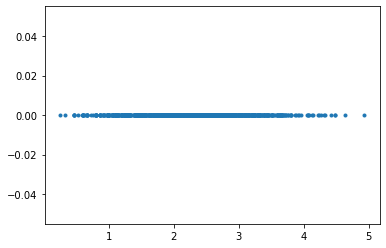

<Figure size 720x360 with 0 Axes>

In [6]:
def plot_at_y(arr, val, **kwargs):
    plt.plot(arr, np.zeros_like(arr) + val, '.', **kwargs)
    plt.figure(figsize=(10, 5))
    plt.show()
plot_at_y(df_ESG['ESG_score'], val=0)

<ipython-input-21-5e890e9c0494>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_ESG['ESG_score'], shade=True, color="b")


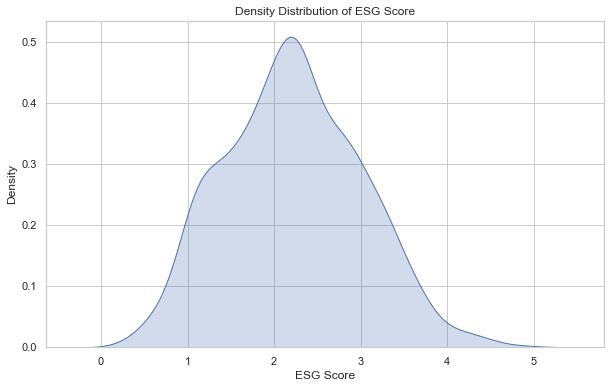

In [21]:
# Plot density distribution of ESG score
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.kdeplot(df_ESG['ESG_score'], shade=True, color="b")
plt.title('Density Distribution of ESG Score')
plt.xlabel('ESG Score')
plt.ylabel('Density')
plt.show()

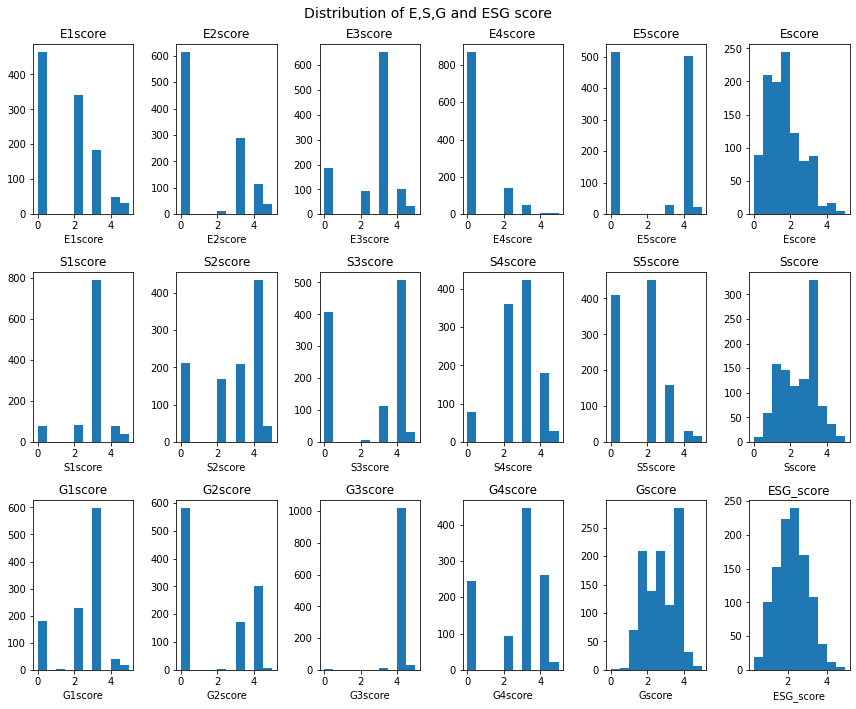

In [132]:
def plot_distribution(df, selected_cols, title, figsize=(10,6), nrows=3, ncols=6):
    num_cols = len(selected_cols)
    # nrows = (num_cols + ncols -1)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    fig.suptitle(title, fontsize=14)
    flat_axes = axes.flat

    for i, col in enumerate(selected_cols):
        try:
            ax = flat_axes[i]

            ax.hist(df[col])
            ax.set_title(col)
            ax.set_xlabel(col)
        except KeyError:
            print(f"Column '{col}' not found")
    for ax in flat_axes[len(selected_cols):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

selected_cols = ['E1score', 'E2score', 'E3score', 'E4score', 'E5score', 'Escore',
    'S1score', 'S2score', 'S3score', 'S4score', 'S5score', 'Sscore', 
    'G1score', 'G2score', 'G3score', 'G4score','Gscore', 'ESG_score']

plot_distribution(df_ESG, selected_cols, "Distribution of E,S,G and ESG score", figsize=(12,10))

In [20]:
def plot_distribution_plotly(df, selected_cols, title, nrows=3, ncols=6):
    fig = make_subplots(rows=nrows, cols=ncols, subplot_titles=selected_cols)

    for i, col in enumerate(selected_cols, start=1):
        row = (i - 1) // ncols + 1
        col_index = (i - 1) % ncols + 1  # Rename the variable to avoid conflict
        fig.add_trace(
            go.Histogram(x=df[col], name=col),
            row=row, col=col_index  # Use the renamed variable here
        )

    fig.update_layout(title=title, showlegend=False)
    fig.show()

# Assuming df_ESG is your DataFrame
selected_cols = ['E1score', 'E2score', 'E3score', 'E4score', 'E5score', 'Escore',
                 'S1score', 'S2score', 'S3score', 'S4score', 'S5score', 'Sscore', 
                 'G1score', 'G2score', 'G3score', 'G4score','Gscore', 'ESG_score']

plot_distribution_plotly(df_ESG, selected_cols, "Distribution of E, S, G, and ESG scores", nrows=3, ncols=6)

In [7]:
def analyze_data(df, normality_test='jarquebera'):
    cols_to_analyze = [col for col in df.columns if col not in ['industry_id']]

    results={}
    for col in cols_to_analyze:
        # 計算敘述統計
        results[col] = {
            'Mean':  df[col].mean(),
            'St.dev': df[col].std(), 
            'Skewness': df[col].skew(), 
            'Kurtosis': df[col].kurt()
        }
        if normality_test == 'jarquebera':
            statistic, _ = stats.jarque_bera(df[col])
            results[col]['Normality test'] = f"{statistic:.4f}"

    return pd.DataFrame(results).transpose() # Convert to DataFrame

In [10]:
results_df = analyze_data(df_train.copy())
print(results_df.to_string(float_format='{:.4f}'.format))
# 輸出到excel
table4_path="ESG_score_stat.xlsx"

# Create a Pandas ExcelWriter object
writer =  pd.ExcelWriter(table4_path)
results_df.to_excel(writer, sheet_name ='ESG_score_stat.xlsx')
writer.save()

                Mean  St.dev Skewness Kurtosis Normality test
Q1            1.8361  0.7783   2.5522  13.2819      8926.5033
Q2A           7.9841  0.2948 -23.3300 581.5380  15005219.2383
Q3            2.1170  1.0615   0.0998  -1.5905       114.0764
Q4            1.5094  0.9003   1.5120   0.8892       440.2144
Q5            1.2444  0.6660   2.9009   7.9724      4291.6930
Q6            1.1685  0.5352   3.5050  12.3489      8897.1628
Q7            1.8258  1.0316   0.5943  -1.3373       142.1998
Q8            1.3624  0.8127   2.0606   2.8586      1112.4949
Q9            5.5637  1.2110  -2.6635   5.7988      2738.6941
Q10           5.1985  1.7034  -1.7900   1.4501       660.7086
Q11           2.6479  0.8415  -1.1711   0.1617       244.5308
Q12           5.7294  0.9420  -3.5421  11.8562      8418.1122
Q13           1.2725  0.7006   2.4174   4.4989      1927.3408
Q14           1.3015  0.7094   2.1914   3.4667      1380.5062
Q15           1.0833  0.3668   5.2211  30.3784     45507.0176
Q16     

In [16]:
table_ESG_df = analyze_data(df_ESG.copy())
print(table_ESG_df.to_string(float_format='{:.4f}'.format))
# 輸出到excel
table5_path="ESG5_stat.xlsx"

# Create a Pandas ExcelWriter object
writer =  pd.ExcelWriter(table5_path)
table_ESG_df.to_excel(writer, sheet_name ='ESG5_stat.xlsx')
writer.save()

              Mean St.dev Skewness Kurtosis Normality test
E1score     1.4841 1.4446   0.4055  -0.8569        61.9884
E2score     1.4476 1.7377   0.5118  -1.4217       136.2968
E3score     2.5393 1.2993  -0.9495   0.1552       160.9982
E4score     0.4541 0.9933   2.0817   3.5657      1327.9096
E5score     2.0684 2.0056  -0.0388  -1.9539       169.5495
S1score     2.8567 0.9706  -1.3803   3.6204       914.1844
S2score     2.7341 1.5647  -0.7362  -0.7805       123.4449
S3score     2.3858 1.9136  -0.3724  -1.7301       157.4388
S4score     2.6639 1.0799  -0.5857   0.7944        88.3274
S5score     1.4888 1.3006   0.2232  -0.7561        34.4182
G1score     2.3464 1.1903  -0.9240   0.1426       152.3715
G2score     1.6573 1.8487   0.2845  -1.8042       158.7687
G3score     3.9991 0.3196  -6.9219  93.4571    393505.0608
G4score     2.5066 1.4976  -0.7365  -0.7864       123.9312
E1_weighted 2.9682 2.8892   0.4055  -0.8569        61.9884
E2_weighted 2.8951 3.4755   0.5118  -1.4217       136.29

- ESG boxplot

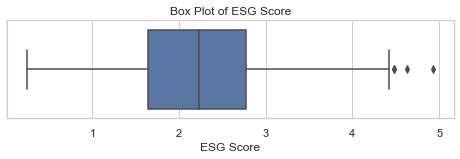

In [202]:
# Set the style of the seaborn plots
sns.set(style="whitegrid")

# Draw the box plot of ESG score
plt.figure(figsize=(8, 1.8))
sns.boxplot(x='ESG_score', data=df)
plt.title('Box Plot of ESG Score')
plt.xlabel('ESG Score')
plt.show()

In [31]:
#不同產業別的平均ESG分數
mean_ESGs = df.groupby('industry_id')['ESG_score'].mean().tolist()
print(mean_ESGs)

[2.847115384615385, 2.8750000000000004, 2.4620370370370366, 2.0037037037037035, 1.6799999999999997, 1.6315476190476186, 1.7080645161290327, 1.507777777777778, 2.075, 2.7347826086956526, 2.6212121212121215, 2.4705555555555554, 1.6880952380952383, 2.032338308457711, 2.688888888888889, 2.447712418300655, 2.8161616161616156, 2.7933333333333334, 1.8991071428571424, 2.275490196078431, 2.929166666666667, 2.4972222222222222, 1.895833333333333, 2.1727272727272733, 1.7333333333333334]


- ESG, E, S, G (3D)

In [147]:
# Create a 3D scatter plot
fig = px.scatter_3d(df_ESG, x='Escore', y='Sscore', z='ESG_score', color='Gscore',
    color_continuous_scale='Viridis', opacity=0.7, 
    title="3D scatter plot of E, S, G, and ESG")
fig.update_traces(marker_size=4)
# Set axis labels
fig.update_layout(scene=dict(xaxis_title='Escore', yaxis_title='Sscore', zaxis_title='ESGscore'))

fig.show()

In [15]:
df['外銷比重'].fillna(value=0, inplace=True)
X = df[['industry_id']]
y = df['ESG_score']

##### 普普通通OLS

In [17]:
model = LinearRegression()
model.fit(X, y)

# Evaluate the model
r2_score = model.score(X, y)
print(f"R-squared value: {r2_score}")

R-squared value: 0.002877589773612077


##### 分群

- 依產業類別(industry_id)

c:\Users\mayda\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


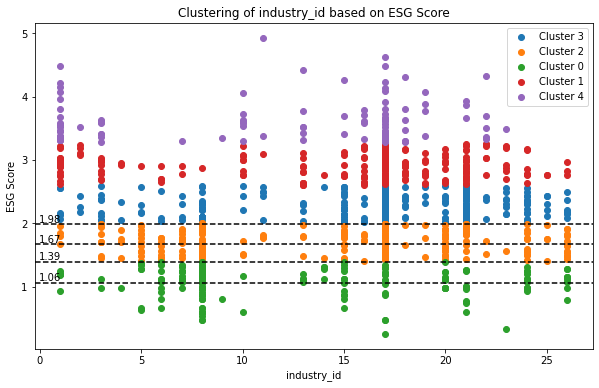

[1.0588015  2.90825893 1.71917344 2.2835477  3.62431193]


In [17]:
df2 = df[['industry_id','ESG_score']].copy()

numeric_df = df[['ESG_score']]  # Selecting only the ESG_score column for clustering

# Perform K-means clustering
kmeans = KMeans(n_clusters=5)  # You can adjust the number of clusters as needed
kmeans.fit(numeric_df)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
cluster_edges = [(centroids[0]+centroids[i])/2 for i in range(len(centroids)-1)]

# Add cluster labels to the DataFrame
df2['cluster'] = labels

# Plotting
plt.figure(figsize=(10, 6))

for i, edge in enumerate(cluster_edges):
    plt.axhline(y=edge[0], color='black', linestyle='--')
    plt.text(0.5, edge[0], f'{edge[0]:.2f}', ha='center', va='bottom')

for cluster_label in df2['cluster'].unique():
    cluster_data = df2[df2['cluster'] == cluster_label]
    plt.scatter(cluster_data['industry_id'], cluster_data['ESG_score'], label=f'Cluster {cluster_label}')

plt.xlabel('industry_id')
plt.ylabel('ESG Score')
plt.title('Clustering of industry_id based on ESG Score')
plt.legend()
plt.show()

print(centroids[: ,0])

In [41]:
# Calculate the count of factories in each cluster for each industry
industry_cluster_counts = df2.groupby(['industry_id', 'cluster']).size().unstack(fill_value=0)

# Calculate the percentage of factories in each cluster for each industry
industry_cluster_percentages = industry_cluster_counts.div(industry_cluster_counts.sum(axis=1), axis=0) * 100
print(industry_cluster_percentages)

# 輸出到excel
table3_path="Industry_ESG_clusters.xlsx"

# Create a Pandas ExcelWriter object
writer =  pd.ExcelWriter(table3_path)
industry_cluster_percentages.to_excel(writer, sheet_name ='Industry_ESG_cluster.xlsx')
writer.save()


cluster              0          1          2
industry_id                                 
1            19.230769  13.461538  67.307692
2            37.500000   0.000000  62.500000
3            41.666667  19.444444  38.888889
4            44.444444  33.333333  22.222222
5            40.000000  56.000000   4.000000
6            32.142857  64.285714   3.571429
7            29.032258  61.290323   9.677419
8            34.166667  65.000000   0.833333
9             0.000000  50.000000  50.000000
10           13.043478  21.739130  65.217391
11           72.727273   0.000000  27.272727
13           40.000000  20.000000  40.000000
14           14.285714  71.428571  14.285714
15           56.716418  29.850746  13.432836
16           36.666667  10.000000  53.333333
17           51.764706  15.294118  32.941176
18           36.363636   3.030303  60.606061
19           35.000000   5.000000  60.000000
20           46.428571  41.071429  12.500000
21           65.686275  12.745098  21.568627
22        

- 依標準化後的資料去做ESG分群

c:\Users\mayda\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


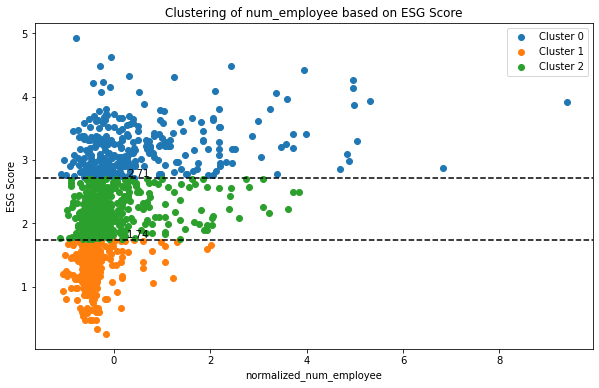

[3.20904437 1.2691886  2.21227884]


In [42]:
df0 = df_norm[['normalized_num_employee','ESG_score']].copy()

numeric_df = df0[['ESG_score']]  # Selecting only the ESG_score column for clustering

# Perform K-means clustering
kmeans = KMeans(n_clusters=3)  # You can adjust the number of clusters as needed
kmeans.fit(numeric_df)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
cluster_edges = [(centroids[i]+centroids[2])/2 for i in range(len(centroids)-1)]

# Add cluster labels to the DataFrame
df0['cluster'] = labels

# Plotting
plt.figure(figsize=(10, 6))

for i, edge in enumerate(cluster_edges):
    plt.axhline(y=edge[0], color='black', linestyle='--')
    plt.text(0.5, edge[0], f'{edge[0]:.2f}', ha='center', va='bottom')

for cluster_label in df2['cluster'].unique():
    cluster_data = df0[df0['cluster'] == cluster_label]
    plt.scatter(cluster_data['normalized_num_employee'], cluster_data['ESG_score'], label=f'Cluster {cluster_label}')

plt.xlabel('normalized_num_employee')
plt.ylabel('ESG Score')
plt.title('Clustering of num_employee based on ESG Score')
plt.legend()
plt.show()

print(centroids[: ,0])

- 依成立時間(year)

c:\Users\mayda\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


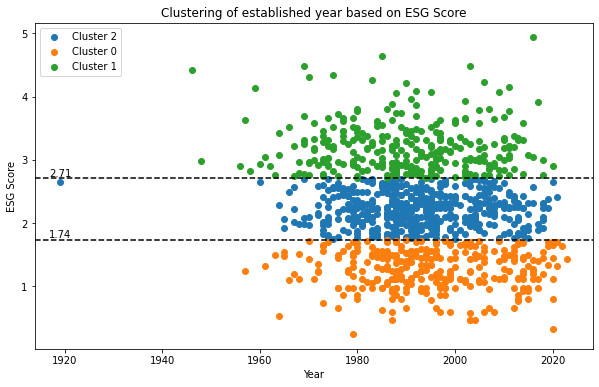

In [72]:
dfy = df[['year','ESG_score']].copy()

numeric_df = df[['ESG_score']]  # Selecting only the ESG_score column for clustering

# Perform K-means clustering
kmeans = KMeans(n_clusters=3)  # You can adjust the number of clusters as needed
kmeans.fit(numeric_df)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
cluster_edges = [(centroids[i]+centroids[2])/2 for i in range(len(centroids)-1)]

# Add cluster labels to the DataFrame
dfy['cluster'] = labels

# Plotting
plt.figure(figsize=(10, 6))

for i, edge in enumerate(cluster_edges):
    plt.axhline(y=edge[0], color='black', linestyle='--')
    plt.text(1919, edge[0], f'{edge[0]:.2f}', ha='center', va='bottom')

for cluster_label in dfy['cluster'].unique():
    cluster_data = dfy[dfy['cluster'] == cluster_label]
    plt.scatter(cluster_data['year'], cluster_data['ESG_score'], label=f'Cluster {cluster_label}')

plt.xlabel('Year')
plt.ylabel('ESG Score')
plt.title('Clustering of established year based on ESG Score')
plt.legend()
plt.show()

In [75]:
# Create a 3D scatter plot
fig = px.scatter_3d(df, x='year', y='num_employee', z='ESG_score', color='industry_id',
    color_continuous_scale='Viridis', opacity=0.7, 
    title="3D scatter plot of 成立時間, 在台員工數, and ESG")
fig.update_traces(marker_size=4)
# Set axis labels
fig.update_layout(scene=dict(xaxis_title='成立時間', yaxis_title='在台員工數', zaxis_title='ESGscore'))

fig.show()

In [97]:
# Calculate the count of factories in each cluster for each level of awareness
awareness_cluster_counts = df1.groupby(['Q1', 'cluster']).size().unstack(fill_value=0)

# Calculate the percentage of factories in each cluster for each level of awareness
awareness_cluster_percentages = awareness_cluster_counts.div(awareness_cluster_counts.sum(axis=1), axis=0) * 100
print(awareness_cluster_percentages)

cluster          0           1          2
Q1                                       
1        52.229299   15.923567  31.847134
2        43.851852   26.074074  30.074074
3        12.244898   85.714286   2.040816
4        20.000000   80.000000   0.000000
5        33.333333   66.666667   0.000000
6         0.000000  100.000000   0.000000
7         0.000000  100.000000   0.000000


In [ ]:
# df3 = df[['industry_id','ESG_score', 'revenue', 'Q3', 'Q4', 'Q5', 'Escore', 'Sscore', 'Gscore']].copy()
# df3['cluster'] = labels

# # Group the data by cluster
# grouped = df3.groupby('cluster')

# # Plotting
# fig, axs = plt.subplots(len(df3.columns) - 3, 3, figsize=(15, 5*len(df3.columns) - 1))

# for i, (col, col_data) in enumerate(df3.drop(['cluster'], axis=1).items()):
#     for cluster_label, group_data in grouped:
#         ax = axs[i % (len(df3.columns) - 1), cluster_label]
#         group_data[col].plot(kind='hist', ax=ax)
#         ax.set_title(f'Cluster {cluster_label}')
#         ax.set_xlabel(col)
#         ax.set_ylabel('Frequency')

# plt.tight_layout()
# plt.show()

<AxesSubplot: xlabel='Q4', ylabel='ESG_score'>

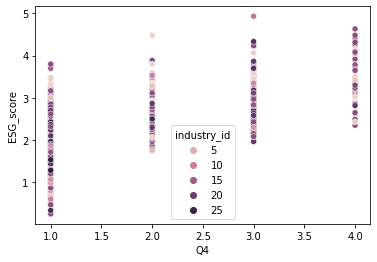

In [61]:
# sns.scatterplot(df, x="Q4", y="ESG_score", hue="industry_id")

##### Heatmap

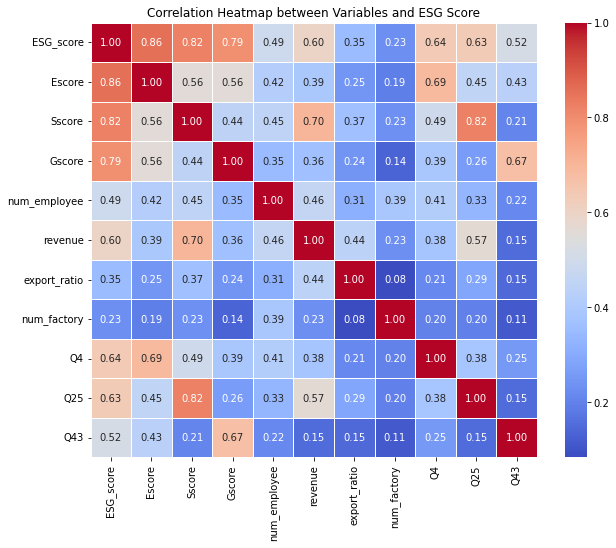

In [21]:
# Calculate the correlation matrix
correlation_matrix = df[['ESG_score', 'Escore', 'Sscore', 'Gscore', 'num_employee', 'revenue', 'export_ratio', 'num_factory', 'Q4', 'Q25', 'Q43']].corr()

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap between Variables and ESG Score')
plt.show()

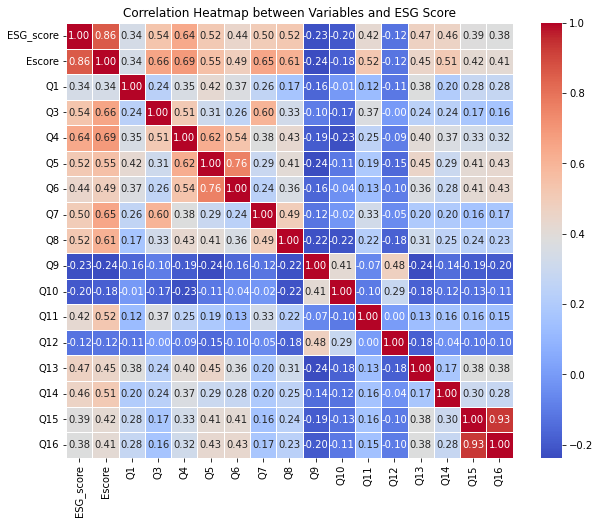

In [11]:
# Calculate the correlation matrix
correlation_matrix = df[['ESG_score', 'Escore', 
    'Q1', 'Q2A', 'Q2B', 'Q2C', 'Q2D', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 
    'Q11', 'Q12', 'Q13', 'Q14', 'Q15', 'Q16']].corr()

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap between Variables and ESG Score')
plt.show()

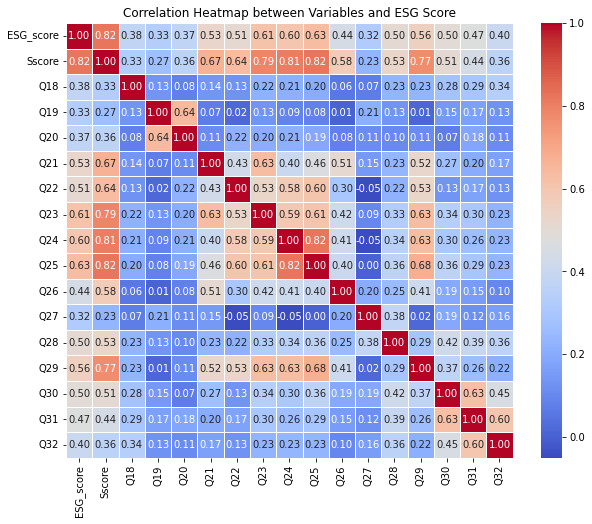

In [14]:
# Calculate the correlation matrix
correlation_matrix = df[['ESG_score', 'Sscore', 
    'Q18', 'Q19', 'Q20', 'Q21', 'Q22', 'Q23', 'Q24', 'Q25', 'Q26', 'Q27', 'Q28', 'Q29', 'Q30', 
    'Q31', 'Q32']].corr()

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap between Variables and ESG Score')
plt.show()

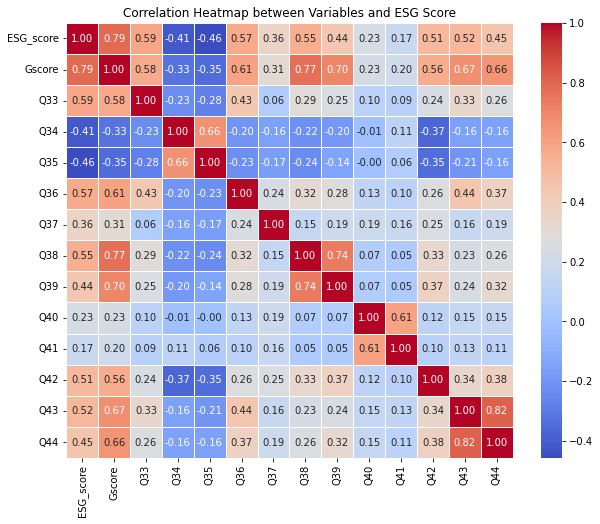

In [13]:
# Calculate the correlation matrix
correlation_matrix = df[['ESG_score', 'Gscore',
    'Q33', 'Q34', 'Q35', 'Q36', 'Q37', 'Q38', 'Q39', 'Q40', 'Q41', 'Q42', 'Q43', 'Q44']].corr()

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap between Variables and ESG Score')
plt.show()

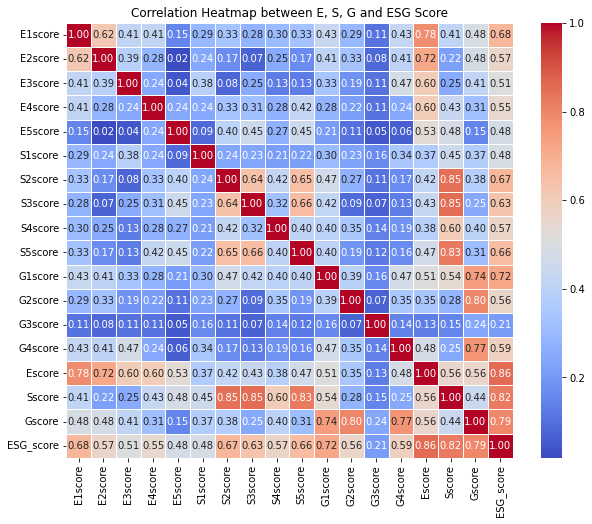

In [12]:
# Calculate the correlation matrix
correlation_matrix = df_ESG[['E1score', 'E2score', 'E3score', 'E4score', 'E5score', 
    'S1score', 'S2score', 'S3score', 'S4score', 'S5score', 
    'G1score', 'G2score', 'G3score', 'G4score','Escore', 'Sscore', 'Gscore','ESG_score']].corr()

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap between E, S, G and ESG Score')
plt.show()

##### 前10個對ESG score最有影響的變數
- 要不要改成用統計方式計算然後補上p-value?

In [9]:
correlation_matrix = df_norm.corr()
corr_with_ESG  = correlation_matrix['ESG_score'].abs().sort_values(ascending=False)
top10_var = corr_with_ESG[1:11]
print(top10_var)

# Perform statistical analysis for the top 10 variables
results = []
for var in top10_var.index:
    corr_coef, p_value = stats.pearsonr(df_norm[var], df_norm['ESG_score'])
    results.append({'Variable': var, 'Pearson Correlation': corr_coef, 'P-Value': p_value})

# Create a DataFrame from the results
results_df = pd.DataFrame(results)

print(results_df)

normalized_Q4              0.478534
normalized_Q25             0.475578
normalized_Q24             0.448886
normalized_Q23             0.441889
normalized_num_employee    0.418288
normalized_Q43             0.412293
normalized_Q3              0.401349
normalized_Q5              0.400176
normalized_Q29             0.399692
normalized_Q8              0.386210
Name: ESG_score, dtype: float64
                  Variable  Pearson Correlation       P-Value
0            normalized_Q4             0.478534  3.223033e-62
1           normalized_Q25             0.475578  2.269998e-61
2           normalized_Q24             0.448886  4.438675e-54
3           normalized_Q23             0.441889  2.842962e-52
4  normalized_num_employee             0.418288  1.755597e-46
5           normalized_Q43             0.412293  4.399779e-45
6            normalized_Q3             0.401349  1.333716e-42
7            normalized_Q5             0.400176  2.430823e-42
8           normalized_Q29             0.399692  3

In [9]:
# Assuming 'df' is your data with features and target variable
X = df_train.drop('ESG_score', axis=1)  # Features
X = X.drop('industry_id', axis=1) 
y = df_train['ESG_score']  # Target variable

In [77]:
mi_scores = mutual_info_score(X, y)
mi_scores_df = pd.DataFrame({'feature': X.columns, 'mi_score': mi_scores})
mi_scores_df = mi_scores_df.sort_values(by='mi_score', ascending=False)

print("Top 10 features by Mutual Information:")
print(mi_scores_df.head(10))


c:\Users\mayda\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous-multioutput values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


ValueError: labels_true must be 1D: shape is (1068, 40)

##### Top and Bottom 10% Companys

In [12]:
def get_top_bottom_percentiles(df, column_name, top_pct=10, bottom_pct=10):

    # Sort the DataFrame by ESG scores
    df_sorted = df.sort_values(by='ESG_score', ascending=False)
    num_factories = len(df_sorted)

    # Select the top 10 and bottom 10 factories
    top_n = int(num_factories * (top_pct /100))
    bottom_n = int(num_factories * (bottom_pct /100))
    total_rank = num_factories

    df_sorted['Rank'] = df_sorted.index.map({
        i: rank if i < top_n else total_rank - rank - 4
        for i, rank in enumerate(range(1, top_n+1))
    })

    top_indices = df_sorted.index[:top_n]
    bottom_indices = df_sorted.index[-bottom_n:]
    return top_indices, bottom_indices

top_indices, bottom_indices = get_top_bottom_percentiles(df, 'ESG_score')
top_factories = df_train.loc[top_indices]
bottom_factories = df_train.loc[bottom_indices]

# # Display the top 10 and bottom 10 factories in a table
# print("Top 5 perc Factories:")
# print(top_factories[['factory_name', 'industry_id', 'county', 'ESG_score', 'Escore', 'Sscore', 'Gscore']])
# print("\nBottom 5 perc Factories:")
# print(bottom_factories[['factory_name', 'industry_id', 'county', 'ESG_score', 'Escore', 'Sscore', 'Gscore']])

In [14]:
top_factories.describe()

,Q1,Q2A,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,Q41,Q42,Q43,Q44,revenue,export_ratio,Q2B,Q2C,Q2D,ESG_score
count,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,...,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000
mean,2.688679,7.943396,3.009434,2.867925,2.283019,1.943396,2.905660,2.311321,4.886792,4.820755,...,3.160377,2.490566,3.094340,3.113208,7.367925,32.184906,7.764151,6.698113,3.169811,3.633962
std,1.340669,0.494353,0.822253,0.905806,1.093311,1.031228,0.856664,1.174030,1.545012,1.683518,...,0.393683,0.918024,0.447816,0.398109,1.259822,33.936265,5.432796,2.289395,3.241022,0.341386
min,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,2.000000,1.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,3.300000
25%,2.000000,8.000000,3.000000,2.000000,1.000000,1.000000,3.000000,1.000000,3.000000,3.000000,...,3.000000,2.000000,3.000000,3.000000,7.000000,0.000000,1.000000,7.000000,1.000000,3.383333
50%,2.000000,8.000000,3.000000,3.000000,2.000000,2.000000,3.000000,2.000000,6.000000,6.000000,...,3.000000,3.000000,3.000000,3.000000,8.000000,20.000000,12.000000,8.000000,1.000000,3.541667
75%,3.000000,8.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,6.000000,6.000000,...,3.000000,3.000000,3.000000,3.000000,8.000000,60.000000,12.000000,8.000000,7.000000,3.758333
max,7.000000,8.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,6.000000,6.000000,...,4.000000,4.000000,4.000000,4.000000,9.000000,100.000000,12.000000,8.000000,8.000000,4.933333


In [15]:
bottom_factories.describe()

,Q1,Q2A,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,Q41,Q42,Q43,Q44,revenue,export_ratio,Q2B,Q2C,Q2D,ESG_score
count,106.000000,106.0,106.000000,106.0,106.0,106.0,106.000000,106.000000,106.000000,106.000000,...,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.0,106.000000,106.000000
mean,1.698113,8.0,1.056604,1.0,1.0,1.0,1.018868,1.018868,5.877358,5.830189,...,2.924528,1.018868,1.849057,1.849057,2.632075,6.424528,11.896226,8.0,7.537736,0.925000
std,0.461257,0.0,0.333243,0.0,0.0,0.0,0.194257,0.194257,0.739406,0.878003,...,0.382924,0.194257,0.993239,0.993239,2.269153,22.358102,1.068414,0.0,1.746695,0.205471
min,1.000000,8.0,1.000000,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,8.0,1.000000,0.250000
25%,1.000000,8.0,1.000000,1.0,1.0,1.0,1.000000,1.000000,6.000000,6.000000,...,3.000000,1.000000,1.000000,1.000000,1.000000,0.000000,12.000000,8.0,8.000000,0.800000
50%,2.000000,8.0,1.000000,1.0,1.0,1.0,1.000000,1.000000,6.000000,6.000000,...,3.000000,1.000000,1.000000,1.000000,1.000000,0.000000,12.000000,8.0,8.000000,0.983333
75%,2.000000,8.0,1.000000,1.0,1.0,1.0,1.000000,1.000000,6.000000,6.000000,...,3.000000,1.000000,3.000000,3.000000,4.000000,0.000000,12.000000,8.0,8.000000,1.100000
max,2.000000,8.0,3.000000,1.0,1.0,1.0,3.000000,3.000000,6.000000,6.000000,...,3.000000,3.000000,3.000000,3.000000,9.000000,100.000000,12.000000,8.0,8.000000,1.133333


In [7]:
def count_factory_by_industry(df, column_name='industry_id'):
    count_factory = df.groupby(column_name)['factory_name'].count()
    count_factory = count_factory.sort_values(ascending=False)
    return count_factory

def perc_factory_by_industry(df, df_specific, column_name='industry_id'):
    all_factory = df.groupby(column_name)['factory_name'].count()
    specific_factory = df_specific.groupby(column_name)['factory_name'].count()
    perc_factory = (specific_factory / all_factory).sort_values(ascending=False)
    return perc_factory


In [8]:
top_factory_counts = count_factory_by_industry(top_factories)
top_factory_df = pd.Series(perc_factory_by_industry(df, top_factories)).to_frame(name="Top Factories")

bottom_factory_counts = count_factory_by_industry(bottom_factories)
bottom_factory_df = pd.Series(perc_factory_by_industry(df, bottom_factories)).to_frame(name="Top Factories")

In [ ]:
# 輸出到excel
table2_path="top_bottom_5perc.xlsx"

# Create a Pandas ExcelWriter object
with pd.ExcelWriter(table2_path) as writer:
    # Export the top 10 companies to the Excel file
    top_factories[['factory_name', 'industry_id', 'county', 'ESG_score', 'Escore', 'Sscore', 'Gscore']].to_excel(writer, sheet_name='Top 10', index=False)
    
    # Export the bottom 10 companies to the Excel file
    bottom_factories[['factory_name', 'industry_id', 'county', 'ESG_score', 'Escore', 'Sscore', 'Gscore']].to_excel(writer, sheet_name='Bottom 10', index=False)

print("Combined top and bottom 5 percentile companies exported to:", table2_path)

- ESG高分的產業都有什麼特徵?

c:\Users\mayda\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
<ipython-input-25-2e6ec13b79cd>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top['cluster'] = labels


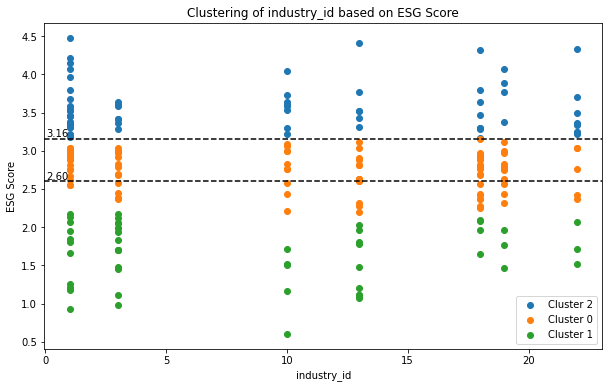

[2.74095745 1.62893082 3.57751323]


In [25]:
df2 = df[['industry_id','year', 'ESG_score', 'num_employee']].copy()
df_top = df2[df2['industry_id'].isin([1, 22, 10, 13, 19, 18, 3])]
numeric_df = df_top[['ESG_score']]  # Selecting only the ESG_score column for clustering

# Perform K-means clustering
kmeans = KMeans(n_clusters=3)  # You can adjust the number of clusters as needed
kmeans.fit(numeric_df)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
cluster_edges = [(centroids[i]+centroids[2])/2 for i in range(len(centroids)-1)]

# Add cluster labels to the DataFrame
df_top['cluster'] = labels

# Plotting
plt.figure(figsize=(10, 6))

for i, edge in enumerate(cluster_edges):
    plt.axhline(y=edge[0], color='black', linestyle='--')
    plt.text(0.5, edge[0], f'{edge[0]:.2f}', ha='center', va='bottom')

for cluster_label in df_top['cluster'].unique():
    cluster_data = df_top[df_top['cluster'] == cluster_label]
    plt.scatter(cluster_data['industry_id'], cluster_data['ESG_score'], label=f'Cluster {cluster_label}')

plt.xlabel('industry_id')
plt.ylabel('ESG Score')
plt.title('Clustering of industry_id based on ESG Score')
plt.legend()
plt.show()

print(centroids[: ,0])

<ipython-input-29-6b520bef9cdd>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top['cluster_label'] = hc.labels_
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


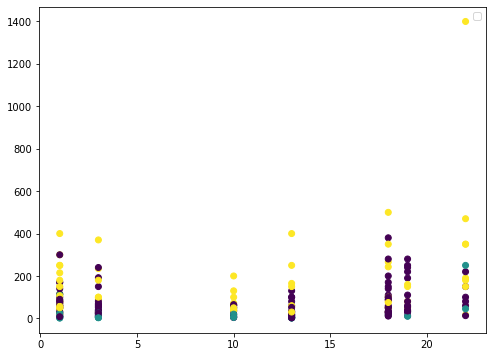

In [29]:
numeric_df = df_top[['ESG_score']]

linkage='ward'
hc = AgglomerativeClustering(n_clusters=3, linkage=linkage)
hc.fit(numeric_df)

df_top['cluster_label'] = hc.labels_
feature1= 'industry_id'
feature2= 'num_employee'

plt.figure(figsize=(8,6))
plt.scatter(df_top[feature1], df_top[feature2], c=df_top['cluster_label'])
plt.legend()
plt.show()